# Can GDP Predict Quality of Life?

An incredibly complicated and eye-opening study by Rahul Iyengar, Matthew Chen, and Sean Boerhout

### Essential Question: How does a country's GDP relate to the quality of life of its individuals?

By analyzing the relationship between a country's GDP and its population density, infant mortality, literacy rate, and even the relative number of phones people own, we can make predictions about how that country's GDP has affected (or serves as a measure of) the quality of life of its inhabitants. 

### Interesting Topics of Analysis

GDP per capita: `GDP ($ per capita)`

GDP per capita vs population density (`Pop. Density (per sq. mi.)`)
GDP per capita vs infant mortality (`Infant mortality (per 1000 births)`)
GDP per capita vs literacy rate (`Literacy (%)`)
GDP per captia vs relative number of phones (`Phones (per 1000)`)


In [1]:
# Import the necessary packages

import pandas as pd                 # For creating and manipulating the DataFrame
import numpy as np                  # For performing mathematical operations on the DataFrame
import scipy.stats as st            # Statistics package for inference
import matplotlib.pyplot as plt     # Plotting package

In [2]:
# Set the plotting style to that of ggplot
plt.style.use('ggplot')

# Import the data
df = pd.read_csv('~/Documents/School/Stats/dataproject/test1/dataframes/countries-of-the-world.csv')

### Clean The Data

We clean our data by dropping useless columns and removing rows with null data. 

We also assign the row indexes to be the names of the countries the data represents and print out the first 5 rows as a preview of the new data. 

In [3]:
# Columsn to be dropped
dropped_cols = ['Arable (%)', 
                'Other (%)', 
                'Climate', 
                'Agriculture', 
                'Industry', 
                'Service']

df.drop(dropped_cols, inplace=True, axis=1)
df.dropna(inplace=True)
df.set_index('Country', inplace=True)

print(df.head())

                                              Region  Population   
Country                                                            
Afghanistan            ASIA (EX. NEAR EAST)             31056997  \
Albania          EASTERN EUROPE                          3581655   
Algeria          NORTHERN AFRICA                        32930091   
American Samoa   OCEANIA                                   57794   
Andorra          WESTERN EUROPE                            71201   

                 Area (sq. mi.) Pop. Density (per sq. mi.)   
Country                                                      
Afghanistan              647500                       48,0  \
Albania                   28748                      124,6   
Algeria                 2381740                       13,8   
American Samoa              199                      290,4   
Andorra                     468                      152,1   

                Coastline (coast/area ratio) Net migration   
Country                   

Now let's start looking at the data, starting with population density, and since we haven't looked at the GDP data yet, here's that too:

In [4]:
# GDP data
print('GDP per captita: \n', df['GDP ($ per capita)'].describe())

# Population density
print('Population density per capita: \n', df['Pop. Density (per sq. mi.)'].describe())

GDP per captita: 
 count      203.000000
mean      9727.586207
std      10213.014779
min        500.000000
25%       1900.000000
50%       5600.000000
75%      14700.000000
max      55100.000000
Name: GDP ($ per capita), dtype: float64
Population denstiy per capita: 
 count      203
unique     195
top       66,6
freq         2
Name: Pop. Density (per sq. mi.), dtype: object


We need a function to plot data with a regression line: 

In [5]:
def plot_data(series_x, series_y, regression_line=True):
  new_df = pd.DataFrame({series_x : df[series_x],
                         series_y : df[series_y]})
  
  # verify that there are no commas in the data - this is probably better to do in the cleaning stage, but whatever
  if isinstance(new_df[series_x][0], str):
    new_df[series_x] = new_df[series_x].replace(',', '.', regex=True)
    new_df[series_x] = pd.to_numeric(new_df[series_x])
  if isinstance(new_df[series_y][0], str):
    new_df[series_y] = new_df[series_y].replace(',', '.', regex=True)
    new_df[series_y] = pd.to_numeric(new_df[series_y])

  # use numpy to create a regression line
  d = np.polyfit(new_df[series_x], new_df[series_y], 1)
  f = np.poly1d(d)

  # print out the regression line
  print(f'Regression line for: {series_y} vs {series_x}: {str(f)}')

  new_df.insert(2, 'Treg', f(new_df[series_x]))
  ax = new_df.plot.scatter(x=series_x, y=series_y)
  if regression_line:
    new_df.plot(x=series_x, y='Treg', color='Red', ax=ax)
    plt.legend([series_x, f'{f}'])

  # plot
  plt.show()

Let's plot!

Regression line for: Pop. Density (per sq. mi.) vs GDP ($ per capita):  
0.03482 x + 22.2


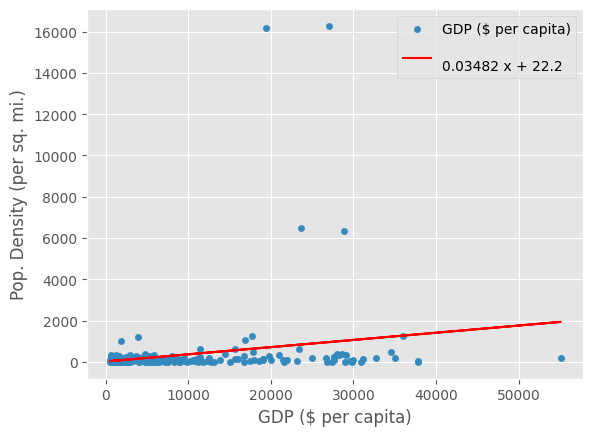

In [6]:
plot_data('GDP ($ per capita)', 'Pop. Density (per sq. mi.)', regression_line=True)